<font size = 3>This script is designed to help identify more AGN with jets from a list of all FIRST survey sources. Once potential candidates have been identified, these can be run through a classifying neural network to check if they are likely to be true AGN with jets. 

This will be helpful to check the success of the neural network, but also has the opportunity to greatly increase the size our existing training set of AGN with jets, which is very important for the accuracy of more complex neural networks.

In [1]:
from astropy.io import fits 
import numpy as np
from selenium import webdriver
import time
from selenium.common.exceptions import NoSuchElementException
import matplotlib.pyplot as plt

In [2]:
# Get data from fits file of all identified FIRST sources
hdulist = fits.open('first_14dec17.fits')
d = hdulist[1].data
n = 100000 # Number of sources we want to look through

ra = np.empty(n)
for i in range(n):
    ra[i] = (d[i])[0] #convert to hours
ra = ra/15

dec = np.empty(n)
for i in range(n):
    dec[i] = (d[i])[1] #in degrees
    
fpeak = np.empty(n)
for i in range(n):
    fpeak[i] = (d[i])[3]
    
fint = np.empty(n)
for i in range(n):
    fint[i] = (d[i])[4]
    
major = np.empty(n)
for i in range(n):
    major[i] = (d[i])[9]
   
minor = np.empty(n)
for i in range(n):
    minor[i] = (d[i])[10]

FileNotFoundError: [Errno 2] No such file or directory: 'first_14dec17.fits'

<font size = 3>From a preliminary search through the data, it became clear that most of the potential AGN with jets in the survey have had each lobe identified as a seperate sources. 

By plotting the distance to the nearest neighbours of the sources, we can see a large spike around zero, showing that many sources exist that are very close together. These are very likely candidates for AGN with jets so these are the sources we should focus on.

In [3]:
d = []
indexes = [] 

for m in range(100000):
    dec_dist = dec - dec[m]
    ra_dist = ra - ra[m]
    distance = np.sqrt(dec_dist**2+ra_dist**2)
    distance[m] = 10*8
    nearest_neighbour = np.min(distance)
    d.append(nearest_neighbour)
    if nearest_neighbour < 0.006:
        i = np.argmin(distance)
        indexes.append(i)
        
indexes = list(dict.fromkeys(indexes))
len(indexes)

dec = dec[indexes]
ra = ra[indexes]
major = major[indexes]
minor = minor[indexes]
fint = fint[indexes]
fpeak = fpeak[indexes]

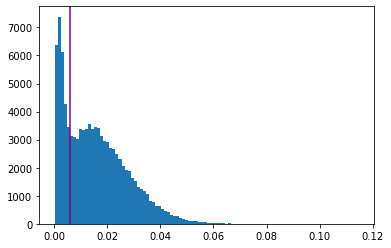

In [4]:
plt.hist(d,bins=100)
plt.axvline(0.006,color='purple')
plt.show()

<font size = 3>Conversely, we can also look at symmetry of sources and their spread to identify and remove point sources. However, this is not as accurate because some of AGN jets appear can appear very symmetrical and we don't want to lose thes sources in the process. 

In [5]:
#suspected point sources
ps = []
#objects of interest
ooi = []  

#check symmetry of sources
for m in range(len(dec)):
    if major[m]/minor[m] <= 1.1:
        ps.append(m)
    else:
        ooi.append(m)

print (len(ps))
print (len(ooi))

5722
19188


In [14]:
#check spread of source using peak/int values
def check_integration(var):
    ps = []
    for m in range(len(var)):
        if fint[m]/fpeak[m] <= 20:
            ps.append(m)
    return ps

ind = check_integration(ooi)
print (len(ind))

19158


In [15]:
def check_brightness(var):
    ps = []
    for m in range(len(var)):
        if fpeak[m] >= 1.5:
            ps.append(m)
    return ps
            
ind = check_brightness(check_integration(ooi))
print (len(ind))

14224


In [16]:
right = []
decl = []
for i in ind:
    right.append(ra[i])
    decl.append(dec[i])

<font size = 3>Webscraper makes it easy to look through the images quickly and determine whether a certain 'filter' is picking out the sources we would expect.

In [18]:
#Webscraper - gets the images quickly so we can look through a few and 
#Open chrome and maximise
driver = webdriver.Chrome()
driver.maximize_window()

#Get webpage that cutouts can be downloaded from
driver.get("https://third.ucllnl.org/cgi-bin/firstcutout")

#Assign required image size (in arcmin) by finding image size element and changing its value
size_arcmin = 5
imagesize = driver.find_element_by_name('ImageSize')
driver.execute_script("arguments[0].value=arguments[1]",imagesize,'{}'.format(size_arcmin))

#len(ra)
#Loop to copy each RA and dec into the cutout search engine and download each image
for i in range(len(decl)):
    try:
        #Finds search box and changes value to a string with RA and dec 
        radec = driver.find_element_by_name('RA')
        driver.execute_script("arguments[0].value=arguments[1]",radec,"{}, {}".format(right[i],decl[i]))
        #Clicks on button to select download type to be a FITS image
        fits_file = driver.find_elements_by_name('ImageType')[2]
        fits_file.click()
        #Clicks submit to download image
        submit = driver.find_element_by_name('.submit')
        submit.click()
    except NoSuchElementException:
        #Exception incase the input RA and dec are out of range of the database
        #Resets the webpage and continues loop through remaining values
        print ('Could not find element {}'.format(i))
        driver.get("https://third.ucllnl.org/cgi-bin/firstcutout")
        time.sleep(3)
        imagesize = driver.find_element_by_name('ImageSize') #in arcmins
        driver.execute_script("arguments[0].value=arguments[1]",imagesize,'{}'.format(size_arcmin))
        continue

In [20]:
def get_clipped_images(filepath,xpix,ypix,sigma):
    '''
    Put FITS data from desired folder into a 3D array
    sigma = how many sigmas from the median background value to sigma clip the data to
    '''
    newpath = filepath.replace(os.sep, '/')
    dirs = os.listdir(newpath)
    n = len(dirs)
    data = np.empty(shape=(n,xpix,ypix),dtype=np.float64)
    for i in range(n):
        fullpath = '{}/{}'.format(newpath,dirs[i])
        d = fits.getdata(fullpath, ext=0)
        d[np.isnan(d)] = 0
        _,median,std = stats.sigma_clipped_stats(d, sigma=sigma)
        d[d<median+sigma*std] = median+sigma*std
        data[i,:,:] = d
    return data

In [21]:
import numpy as np
import os
from astropy.io import fits 
from astropy import stats
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

filepath = r'C:\Users\Cerys\Documents\Physics\Y4 Project\Semester 2\close_sources'
images = get_clipped_images(filepath,167,167,5)

In [29]:
len(images)

14224

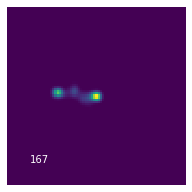

In [77]:
n = 1 # number of objects to plot
cols = 5 # number of objects per row
rows = (n+cols-1)//cols # number of required rows in figure (division that rounds up)

# Plots objects
fig = plt.figure(figsize=(12.6,rows*2.5))
for i in range(n):
    ax = fig.add_subplot(rows, cols, i+1)
    # need vmin and vmax to have the same colormap as the full image
    ax.imshow(images[13722,42:125,42:125], cmap='viridis',origin='lower')
    ax.text(10,10,'{}'.format(167),color='white')
    plt.axis('off')

fig.tight_layout(pad=0.1)
plt.show()

In [29]:
newimage = images[25,:,:]

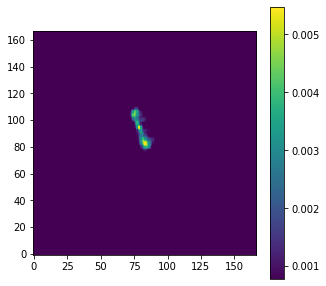

In [30]:
plt.figure(figsize=(5,5))
plt.imshow(newimage,cmap='viridis',origin='lower')
plt.colorbar()
plt.show()

In [36]:
# crops to (roughly) the centre pixel
# could make it a bit more accurate
def centre_crop(images,original_y,original_x,new_y,new_x):
    cropped_images = np.empty(shape=(len(images),new_y,new_x))
    centre_y = int(original_y/2)
    centre_x = int(original_x/2)
    print ('The objects are centred around pixel ({},{})'.format(centre_y,centre_x))
    half_y = int(new_y/2)
    half_x = int(new_x/2)
    ymin = centre_y - half_y
    ymax = ymin + new_y
    xmin = centre_x - half_x
    xmax = xmin + new_x
    for i in range(len(images)):
        cropped_images[i,:,:] = images[i,ymin:ymax,xmin:xmax]
    return cropped_images

cropped_images = centre_crop(images,167,167,83,83)

The objects are centred around pixel (83,83)


In [37]:
np.save('cropped_images.npy', cropped_images)